# 画像生成AIをつくろう（VAE編）

## 概要

- 変分オートエンコーダー（Variational Auto Encoder）
- 2013年にアムステルダム大学の Diederik P.Kingma と Max Welling が発明
- [Auto-Encoding Variational Bayes（arXiv）](https://arxiv.org/abs/1312.6114)
- [VAEのイメージ（Wikipedia）](https://en.wikipedia.org/wiki/Variational_autoencoder)
- 画像を潜在空間に圧縮し（エンコード）、もとの画像に復元する（デコード）するモデル
- エンコード時とデコード時の潜在変数の分布と、元の画像と復元した画像の誤差が小さくなるように学習する
- エンコーダーとデコーダーは同時に学習する
- デコーダーのみ使用することで画像生成AIをつくれる

## 学習の仕組み

![](image/vae.png)


- $x$: データポイント（画像）
- $z$: 潜在変数
- $\phi$: エンコーダーのパラメータ
- $\theta$: デコーダーのパラメータ
- $N$: 独立した $N$ 個のサンプル（複数の画像）

学習の目的は、エンコーダーの品質が最大になるようなパラメータ $\phi$ と $\theta$ を見つけること。

エンコーダーの品質はすべてのデータポイントの対数尤度（もっともらしさ）の足し合わせで表現される。

$$
\log{p_\theta}(x^{(1), \dots, x^{N}}) = \sum_{i=1}^N \log{p_\theta}(x^{(i)})\tag{1}
$$


それぞれのデータポイントの対数尤度は次式で表現され、この値を最大化したい。

$$
\log p_{\mathbf{\theta}}({\bf x}^{(i)})=
D_{KL}(q_{\mathbf{\phi}}({\bf z}|{\bf x}^{(i)})||p_{\mathbf{\theta}}({\bf z}|{\bf x}^{(i)})) +
{\cal L}(\mathbf{\theta},\mathbf{\phi};{\bf x}^{(i)})
\tag{2}
$$

最初の項はKLダイバージェンスと呼ばれ、エンコーダーとデコーダーの潜在変数の分布の距離を表している。（小さいほど良く、常に正）

第二項は、変分下限（VLB, variational lower bound）と呼ばれる目的関数で、最大化したい。

仮に距離が $0$ のとき、対数尤度の最小は目的関数になるので、「下限（lower bound）」と呼ばれている。

目的関数の実態は、復元時の対数尤度の期待値。

$$
\log p_{\mathbf{\theta}}(\mathbf{x}^{(i)})\geq\mathcal{L}(\mathbf{\theta},\mathbf{\phi};\mathbf{x}^{(i)}) =
\mathbb{E}_{q_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x})}\left[-\log q_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x}) +
\log p_{\mathbf{\theta}}(\mathbf{x},\mathbf{z})\right]\tag{3}
$$

式2と3より、目的関数の式に変形できる。

$$
\mathcal{L}(\mathbf{\theta},\mathbf{\phi};\mathbf{x}^{(i)})=
-D_{KL}(q_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x}^{(i)})||p_{\mathbf{\theta}}(\mathbf{z})) +
\mathbb{E}_{q_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x}^{(i)})}\left[\log p_{\mathbf{\theta}}(\mathbf{x}^{(i)}|\mathbf{z})\right]
\tag{4}
$$

つまり、VAEではKLダイバージェンスを最小化し、復元時の対数尤度の期待値を最大化するように学習する。

言い換えると、エンコード時とデコード時の潜在変数の分布の距離を小さくし、元の画像を復元したときのもっともらしさを最大化させる。

実際の実装では上記の目的関数を変形して（論文中の式10）次の損失関数を最小化する。

$$
{\cal L}(\mathbf{\theta},\mathbf{\phi};{\bf x}^{(i)})\simeq\frac{1}{2}\sum_{j=1}^{J}\left(1+\log((\sigma_{j}^{(i)})^{2})-(\mu_{j}^{(i)})^{2}-(\sigma_{j}^{(i)})^{2}\right)+\frac{1}{L}\sum_{l=1}^{L}\log p_{\mathbf{\theta}}({\bf x}^{(i)}|{\bf z}^{(i,l)})
\tag{5}
$$



## 実装

In [10]:
# 0. 準備

# Pytorch: https://pytorch.org/docs/stable/index.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Pytorch Vision: https://pytorch.org/vision/stable/index.html
from torchvision import datasets, transforms

# 計算で使用するデバイス（GPUかCPU）の確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# 1. データセットのダウンロードと前処理
# 今回は MNIST データセット（手書き数字のデータセット）を使用
# 前処理は、画像データ（PIL.Image）をテンソルに変換するだけ
# Wikipedia: https://en.wikipedia.org/wiki/MNIST_database
# PIL.Image: https://pillow.readthedocs.io/en/stable/reference/Image.html
# torch.Tensor: https://pytorch.org/docs/stable/tensors.html

# 訓練データセット
train_dataset = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)

# テストデータセット
test_dataset = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=True)

len(train_dataset), len(test_dataset), train_dataset.data[0].shape, type(train_dataset.data[0])
# 60,000 件と 10,000 件のデータがあり、それぞれ 28x28 の単色画像データ

(60000, 10000, torch.Size([28, 28]), torch.Tensor)

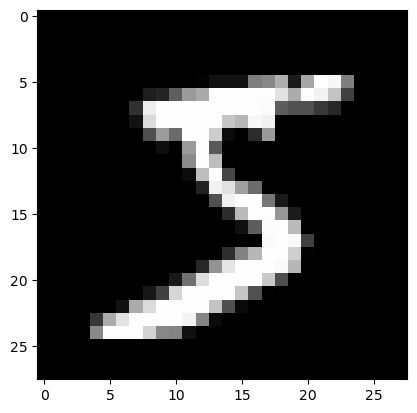

In [12]:
# 画像を表示

import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[0], cmap="gray")

In [13]:
# 2. データローダー作成
# データローダーは学習時にバッチ（データのかたまり）を読み込むためのオブジェクト

# 任意のバッチサイズを指定。大きいほど学習が安定するが、メモリを多く消費する。
batch_size = 100

# 訓練用データローダー
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# テスト用データローダー
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)
# 600 バッチと 100 バッチ

(600, 100)

In [14]:
# 3. VAEモデルの定義

# モデルの構造

class VAE(nn.Module):
    def __init__(self, x_dim=28*28, h_dim1=512, h_dim2=256, z_dim=2):
        super(VAE, self).__init__()

        # 各層の定義
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    # エンコーダー
    # 画像を圧縮し、潜在変数の分布の平均と分散を推定
    def encoder(self, x):
        # 784 -> 512
        x = self.fc1(x)
        x = F.relu(x)

        # 512 -> 256
        x = self.fc2(x)
        x = F.relu(x)

        # 潜在変数の分布の平均を推定
        # 256 -> 2
        mu = self.fc31(x)

        # 潜在変数の分布の分散を推定
        # 256 -> 2
        log_var = self.fc32(x)

        return mu, log_var

    # サンプリング
    # 潜在変数を疑似サンプリング
    def sampling(self, mu, log_var):
        # 潜在空間の標準偏差
        # 対数分散を対数標準偏差に変換し、標準偏差に変換
        std = torch.exp(0.5 * log_var)

        # ランダムな値を生成
        epsilon = torch.randn_like(std)

        # 潜在変数を疑似サンプリング（Reparameterization Trick）
        # https://en.wikipedia.org/wiki/Variational_autoencoder#Reparameterization
        z = epsilon.mul(std).add_(mu)

        return z

    # デコーダー
    # 潜在空間のデータポイントを画像に変換
    def decoder(self, z):
        # 2 -> 256
        z = self.fc4(z)
        z = F.relu(z)

        # 256 -> 512
        z = self.fc5(z)
        z = F.relu(z)

        # 512 -> 784
        z = self.fc6(z)

        # 0-1 の範囲に変換し、画像を復元
        z = F.sigmoid(z)
        return z

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 28*28))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

num_params = 0
for name, param in VAE().named_parameters():
    print(name, param.numel())
    num_params += param.numel()
print("総パラメータ数", num_params)

# パラメータ数は 106万
# 全結合層はパラメータ数が多いので、モデルが大きくなる

fc1.weight 401408
fc1.bias 512
fc2.weight 131072
fc2.bias 256
fc31.weight 512
fc31.bias 2
fc32.weight 512
fc32.bias 2
fc4.weight 512
fc4.bias 256
fc5.weight 131072
fc5.bias 512
fc6.weight 401408
fc6.bias 784
総パラメータ数 1068820


In [15]:
# 4. 学習

# モデルをインスタンス化し、GPUに転送
vae = VAE().to(device)

# 最適化関数はAdamを使用
# 最適化関数とは、モデルのパラメータを更新するためのアルゴリズム
# Adam: https://medium.com/@LayanSA/complete-guide-to-adam-optimization-1e5f29532c3d
optimizer = optim.Adam(vae.parameters())

# 損失関数
# 損失関数とは、モデルの予測と正解の差を評価するためのアルゴリズム
# 式5参照
def loss_function(predicted, x, mu, log_var):
    # KLダイバージェンス
    # 潜在変数の分布と事前分布（標準正規分布として近似）の距離
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # 交差エントロピー（復元したときの誤差）
    reconstruction_loss = F.binary_cross_entropy(predicted, x.view(-1, 28*28), reduction="sum")

    return kl_divergence + reconstruction_loss

train_log = []
test_log = []

num_epochs = 20

for epoch_index in range(num_epochs):
    # 訓練モードに変更
    vae.train()

    train_loss = 0

    # バッチごとに学習。今回は600バッチなので、600回ループを繰り返す
    for batch_index, (data, _) in enumerate(train_loader):
        # データをGPUに転送
        data = data.to(device)

        # 最適化関数を初期化
        optimizer.zero_grad()

        # 画像を圧縮し、復元
        predicted, mu, log_var = vae(data)

        # 損失を計算
        loss = loss_function(predicted, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()

        # モデルのパラメータを更新
        optimizer.step()

        # 100 バッチごとにログを表示
        if batch_index == 0 or (batch_index + 1) % 100 == 0:
            # 今回のバッチの平均損失を計算
            average_loss = loss.item() / len(data)
            print(f"エポック: {epoch_index + 1}/{num_epochs}, バッチ: {batch_index + 1}/{len(train_loader)}, 損失: {average_loss}")

            # 処理したデータ数
            num_processed = batch_index * len(data)

            # 処理したデータの総数
            num_data = len(train_loader.dataset) * epoch_index + num_processed

            # ログに追加
            train_log.append({"num_data": num_data, "average_loss": average_loss})

    train_loss /= len(train_loader.dataset)
    print(f"[訓練] エポック: {epoch_index + 1}/{num_epochs}, 損失: {train_loss}")

    # 評価モードに変更
    vae.eval()

    # 損失を初期化
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            # データをGPUに転送
            data = data.to(device)

            # 画像を圧縮し、復元
            predicted, mu, log_var = vae(data)

            # 損失を合算
            test_loss += loss_function(predicted, data, mu, log_var).item()

    # 平均損失を計算
    test_loss /= len(test_loader.dataset)

    print(f"[評価] エポック: {epoch_index + 1}/{num_epochs}, 損失: {test_loss}\n")

    # ログに追加
    test_log.append({"num_data": len(train_loader.dataset) * epoch_index, "average_loss": test_loss})

エポック: 1/20, バッチ: 1/600, 損失: 544.0490625
エポック: 1/20, バッチ: 100/600, 損失: 185.9771484375
エポック: 1/20, バッチ: 200/600, 損失: 184.8311328125
エポック: 1/20, バッチ: 300/600, 損失: 175.68431640625
エポック: 1/20, バッチ: 400/600, 損失: 170.9255078125
エポック: 1/20, バッチ: 500/600, 損失: 157.813017578125
エポック: 1/20, バッチ: 600/600, 損失: 168.52478515625
[訓練] エポック: 1/20, 損失: 182.18455888671875
[評価] エポック: 1/20, 損失: 163.7318171875

エポック: 2/20, バッチ: 1/600, 損失: 164.61171875
エポック: 2/20, バッチ: 100/600, 損失: 161.451123046875
エポック: 2/20, バッチ: 200/600, 損失: 160.9866015625
エポック: 2/20, バッチ: 300/600, 損失: 166.31560546875
エポック: 2/20, バッチ: 400/600, 損失: 157.843603515625
エポック: 2/20, バッチ: 500/600, 損失: 157.6850390625
エポック: 2/20, バッチ: 600/600, 損失: 155.9112109375
[訓練] エポック: 2/20, 損失: 159.21920009765626
[評価] エポック: 2/20, 損失: 155.88059521484374

エポック: 3/20, バッチ: 1/600, 損失: 152.95419921875
エポック: 3/20, バッチ: 100/600, 損失: 154.95181640625
エポック: 3/20, バッチ: 200/600, 損失: 154.051982421875
エポック: 3/20, バッチ: 300/600, 損失: 146.8518359375
エポック: 3/20, バッチ: 400/600, 損失: 

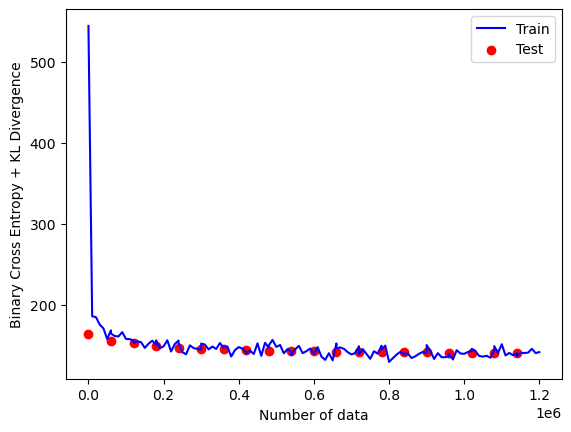

In [16]:
# 5. 学習結果の可視化
import matplotlib.pyplot as plt

train_x = [log["num_data"] for log in train_log]
train_y = [log["average_loss"] for log in train_log]
test_x = [log["num_data"] for log in test_log]
test_y = [log["average_loss"] for log in test_log]

plt.plot(train_x, train_y, label="train", color="blue")
plt.scatter(test_x, test_y, label="test", color="red")
plt.legend(["Train", "Test"])
plt.xlabel("Number of data")
plt.ylabel("Binary Cross Entropy + KL Divergence")
plt.show()

# だいたい15エポックで学習が収束している

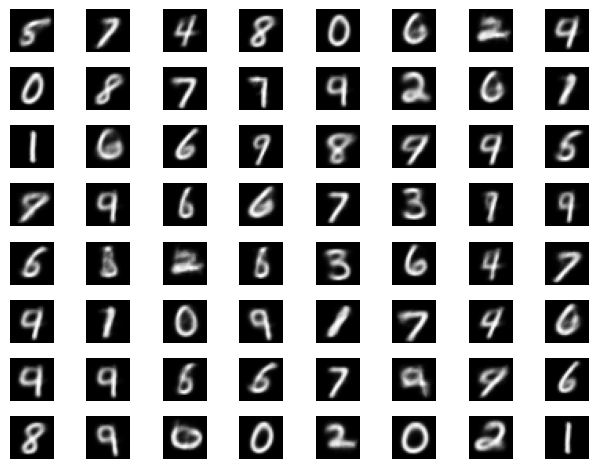

In [17]:
# 64枚の画像をランダムに生成
num_images = 64

# 評価モードに変更
vae.eval()

# 乱数を生成（64枚分の平均と分散）
# 潜在空間の次元は 2
z = torch.randn(64, 2).to(device)

# デコーダーを使い、画像を生成
samples = vae.decoder(z)
samples = samples.view(num_images, 1, 28, 28)

# 画像を表示
fig, axes = plt.subplots(8, 8)
for i in range(num_images):
    ax = axes[i // 8, i % 8]
    image = samples[i].cpu().detach().numpy().squeeze()
    ax.imshow(image, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

# 少しぼやけている
# https://arxiv.org/pdf/1312.6114
# Fig5を見ると、潜在空間の次元を増やすと、はっきりとした数字を生成できる

## 次は？

- z_dim（潜在変数の次元）を 5, 10, 20 と増やしてみよう
- 論文にある Frey Face データセットを探してダウンロードして、VAEを実装してみよう